<a href="https://colab.research.google.com/github/AmrtanshuBharadwaj/DualVirusEpidemic/blob/main/ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64, SeedSequence

#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7a3d26b210c0>


In [ ]:
def calculate_node_propensities(G, beta, mu):

    N = len(G)

    nx.set_node_attributes(G, 0., 'lambda')

    for i in range(N):
        #--- If node is susceptible calculate total propensity for infection: ---
        if G.nodes[i]['state'] == 0:
            # Get i's neighbors:
            neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)]

            # Total node rate from number of neighbors that are infectious:
            lambda_i = beta * np.sum([state==1 for state in neighbor_states])

            # Set node propensity and draw waiting time:
            if lambda_i > 0.:
                G.nodes[i]['lambda'] = lambda_i

                u_i = rg.random()
                G.nodes[i]['tau'] = -np.log(1. - u_i) / lambda_i

        #--- If node is infectious set propensity to mu: ---
        elif G.nodes[i]['state'] == 1:
            # Set node propensity:
            G.nodes[i]['lambda'] = mu

            u_i = rg.random()
            G.nodes[i]['tau'] = -np.log(1. - u_i) / mu
    return()

##################################################################################################
##################################################################################################

def draw_next_event_first_reaction(G):
    '''Input: the network G.
    Output: selected reaction channel, i_selected, and the waiting time until the event, tau.'''

    # Get waiting times for active reaction channels from G:
    node_indices  = list(nx.get_node_attributes(G, 'tau'))
    waiting_times = list(nx.get_node_attributes(G, 'tau').values())

    # Select reaction with minimal waiting time:
    tau = np.min(waiting_times)

    i_selected = np.where(waiting_times == tau)[0][0]

    return(i_selected, tau)

##################################################################################################
##################################################################################################

def update_states(G, X, tau, i_selected):
    # State counts:
    S, I, R = X

    # Get node indices for active reaction channels from G:
    node_indices = list(nx.get_node_attributes(G, 'tau'))

    # Get node id corresponding to reaction channel i_0
    i_node = node_indices[i_selected]

    #--- Update waiting times for remaining nodes: ---
    node_indices.pop(i_selected)

    for j in node_indices:
        G.nodes[j]['tau'] -= tau

    #===== Update network state: =====
    state_before = G.nodes[i_node]['state']

    #--- If state_before was S, update to I: ---
    if state_before==0:
        # Update state counts:
        S -= 1
        I += 1

        # Update state of node i_selected (S -> I):
        G.nodes[i_node]['state'] = 1

        # Update node i_selected's propensity:
        G.nodes[i_node]['lambda'] = mu

        # Draw new waiting time for i_selected:
        u_i = rg.random()
        G.nodes[i_node]['tau'] = -np.log(1. - u_i) / mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_node) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                # Update j's propensity:
                G.nodes[j]['lambda'] += beta

                # Draw new waiting time for j:
                u_j = rg.random()
                G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['lambda']

    #--- Else, if state_before was I, update to R: ---
    else: # (Note that this is a simple else statement since state_before is either S or I)
        # Update state counts:
        I -= 1
        R += 1

        # Update state of node in graph:
        G.nodes[i_node]['state'] = 2

        # Remove i from reaction channels:
        G.nodes[i_node]['lambda'] = 0.
        del G.nodes[i_node]['tau']

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_node) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                # Update j's propensity:
                G.nodes[j]['lambda'] -= beta

                # If node propensity is zero remove channel:
                if np.isclose(G.nodes[j]['lambda'], 0.):
                    del G.nodes[j]['tau']

                # Else, draw new waiting time for j:
                else:
                    u_j = rg.random()
                    G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['lambda']

    return([S, I, R])

##################################################################################################
##################################################################################################

def first_reaction_method_SIR_graph_linear(G, beta, mu, T):

    #--- Initialization: ---
    node_states = nx.get_node_attributes(G, 'state')

    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I

    # Calculate and store node propensities:
    calculate_node_propensities(G, beta, mu)

    # Set initial time t = 0:
    t = 0

    # Vector to save temporal evolution of state numbers over time:
    X_t = []
    X_t.append([t, S, I, R])

    #--- Keep drawing events until t >= T: ---
    while t < T:
        # Check if no putative waiting times are left (no more reactions can happen):
        if len(nx.get_node_attributes(G,'tau')) == 0:
            X_t.append([T, S, I, R])
            break

        #===== First reaction event sampling step: =====
        i, tau = draw_next_event_first_reaction(G)


        # Add waiting time to wall time:
        t += tau

        #===== Update: =====
        [S, I, R] = update_states(G, [S, I, R], tau, i)

        #--- Save current state numbers to X_t: ---
        X_t.append([t, S, I, R])

    return(np.array(X_t).transpose())


**ER Network Analysis**

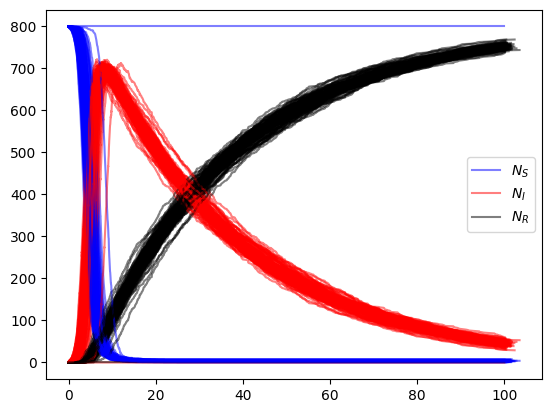

In [ ]:
##Your normal simulations

#--- Simulation parameters: ---
beta   = 0.285   # Infection rate
mu     = 0.03  # Recovery rate
k      = 6     # Mean degree
N      = 800   # Number of nodes
T      = 100   # Simulation duration

Q = 100

G0 = nx.gnm_random_graph(n=N, m=k*N/2)

min_length = float('inf')  # Initialize with a large value

# Initialize an empty list to store R0 values at each time step in each simulation
R0_values = []
Rav_values = []

# Set a fixed number of time steps
num_time_steps = 100  # You can adjust this number as needed

X_array = []

for q in range(Q):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)


    # Update the minimum length(FOR AVG)
    min_length = min(min_length, X_t.shape[1])

    # Calculate R0 at each time step and store it in R0_values
    R0_simulation = [beta / mu * (S / N) for S in X_t[1]]
    R0_values.append(R0_simulation)




#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]

ax.legend(legends)

In [ ]:
average_degree = sum(dict(G0.degree()).values()) / N

print(f"The average degree of the graph is: {average_degree}")

The average degree of the graph is: 6.0


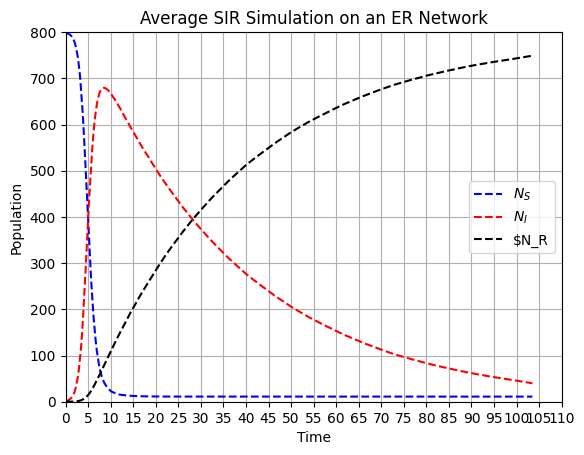

In [ ]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np

common_time = []

# Assuming you have X_array defined earlier

for X in X_array:
  common_time.extend(X[0])
common_time = list(set(common_time))
common_time.sort()

interpolated_s_values = []
interpolated_i_values = []
interpolated_r_values = []

for X in X_array:
    f_s = interpolate.interp1d(X[0], X[1], kind='linear', fill_value="extrapolate")
    f_i = interpolate.interp1d(X[0], X[2], kind='linear', fill_value="extrapolate")
    f_r = interpolate.interp1d(X[0], X[3], kind='linear', fill_value="extrapolate")

    interpolated_s_values.append(f_s(common_time))
    interpolated_i_values.append(f_i(common_time))
    interpolated_r_values.append(f_r(common_time))

average_s = np.mean(interpolated_s_values, axis=0)
average_i = np.mean(interpolated_i_values, axis=0)
average_r = np.mean(interpolated_r_values, axis=0)

colors = ['b', 'r', 'k']
legends = [r'$N_S$', r'$N_I$', r'$N_R']

fig = plt.figure()
ax = plt.subplot()

# Stepsize
# Change the step size for X-axis and Y-axis to 0.5
step_size_x = 5
step_size_y = 100

# Calculate the number of ticks needed based on the range
x_ticks = [i * step_size_x for i in range(int(110 / step_size_x) + 1)]
y_ticks = [i * step_size_y for i in range(int(800 / step_size_y) + 1)]

plt.xticks(x_ticks)
plt.yticks(y_ticks)

ax.plot(common_time, average_s, c=colors[0], linestyle='--')
ax.plot(common_time, average_i, c=colors[1], linestyle='--')
ax.plot(common_time, average_r, c=colors[2], linestyle='--')
ax.legend(legends)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average SIR Simulation on an ER Network')

plt.xlim(0, 110)
plt.ylim(0, 800)

plt.grid()
plt.show()


In [ ]:
# Find the peak time for infection
peak_time = np.argmax(average_i)
peak_infections = average_i[peak_time]  # Number of infected individuals at the peak time

print("Peak time for infection:", common_time[peak_time])
print("Peak number of infections:", peak_infections)

Peak time for infection: 8.559127947980988
Peak number of infections: 679.5258721665919


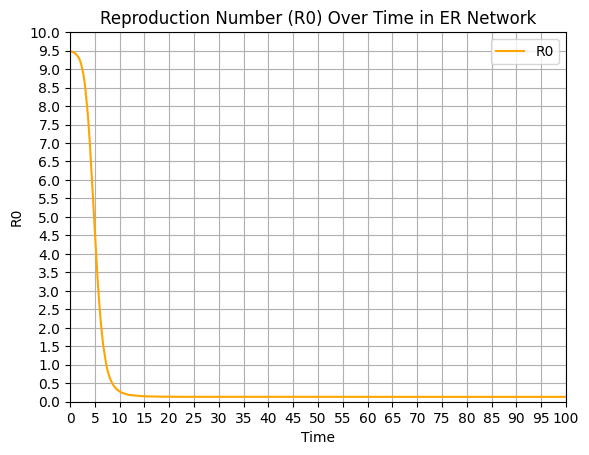

In [ ]:
import matplotlib.pyplot as plt

# Calculate R0 at each time step and store it in R0_values
R0_simulation = [beta / mu * (S / N) for S in average_s]

fig = plt.figure()
ax = plt.subplot()

# Change the step size for X-axis and Y-axis
step_size_x = 5
step_size_y = 0.5

# Calculate the number of ticks needed based on the range
x_ticks = [i * step_size_x for i in range(int(100 / step_size_x) + 1)]
y_ticks = [i * step_size_y for i in range(int(10 / step_size_y) + 1)]

plt.xticks(x_ticks)
plt.yticks(y_ticks)

ax.plot(common_time, R0_simulation, c='orange')

# You can adjust the legends and grid as needed
legends = ["R0"]
ax.legend(legends)

plt.xlabel('Time')
plt.ylabel('R0')
plt.title('Reproduction Number (R0) Over Time in ER Network')

# Set the axis limits
plt.xlim(0, 100)
plt.ylim(0, 10)

plt.grid()
plt.show()
